In [6]:
#determing the shape of the dataset
import os
def count_files(folder_path):
    count=0
    for _,_, files in os.walk(folder_path):
        count += len(files)
    return count
dataset_folder='C:/Users/ADMIN/Downloads/LEARN DATASCIENCE/fingerprint_datasets'
real_folder=os.path.join(dataset_folder,'Real')
num_real=count_files(real_folder)
altered_folder=os.path.join(dataset_folder,'Altered')
altered_easy=os.path.join(altered_folder,'Altered-Easy')
altered_medium=os.path.join(altered_folder,'Altered-Medium')
altered_hard=os.path.join(altered_folder,'Altered-Hard')
num_altered_easy=count_files(altered_easy)
num_altered_medium=count_files(altered_medium)
num_altered_hard=count_files(altered_hard)
print("Real:", num_real)
print("Altered Easy:", num_altered_easy)
print("Altered Medium:", num_altered_medium)
print("Altered Hard:", num_altered_hard)
print("Total Altered:", num_altered_easy + num_altered_medium + num_altered_hard)
print("Dataset Shape:", num_altered_easy + num_altered_medium + num_altered_hard + num_real)


Real: 6000
Altered Easy: 17931
Altered Medium: 17067
Altered Hard: 14272
Total Altered: 49270
Dataset Shape: 55270


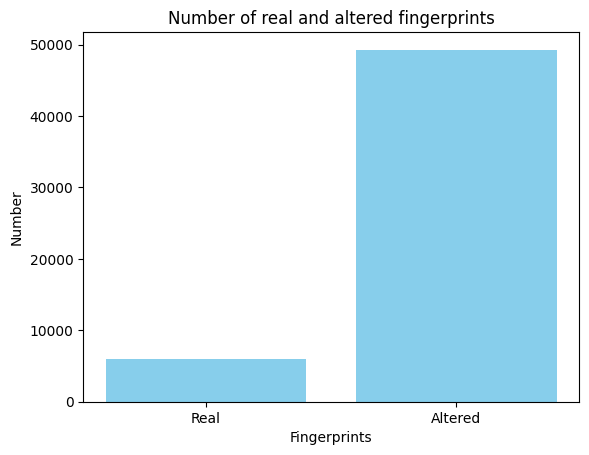

In [7]:
#histogram to show the number of real and altered fingerprints
altered_real = ['Real', 'Altered']
nums = [6000,49270 ]

plt.bar(altered_real, nums, color='skyblue')
plt.xlabel('Fingerprints')
plt.ylabel('Number')
plt.title('Number of real and altered fingerprints')
plt.show()

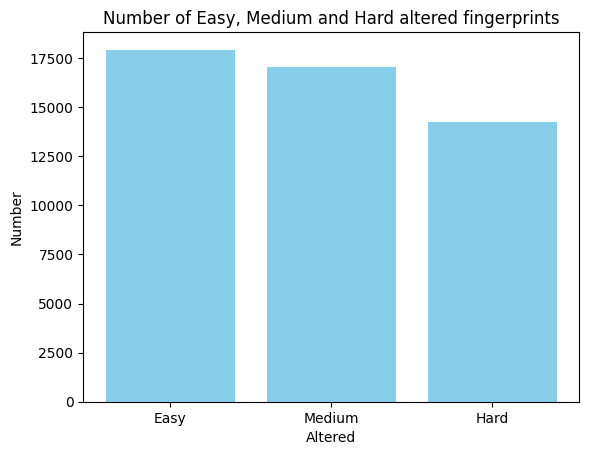

In [8]:
#histogram to show number of easy, medium and hard altered fingrprints
import matplotlib.pyplot as plt

altered = ['Easy', 'Medium', 'Hard']
nums = [17931, 17067, 14272]

plt.bar(altered, nums, color='skyblue')
plt.xlabel('Altered')
plt.ylabel('Number')
plt.title('Number of Easy, Medium and Hard altered fingerprints')
plt.show()

# Fingerprint identification Model

This CNN model takes in a random fingerprint and returns its subject ID as well as the fingername. It therefore includes two models for subject ID and fingername identification.

# Preprocessing

In [2]:
#importing libraries
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#function to load images and extract data
img_size = 96
def load_data(path, train=True):
    print("Loading data from: ", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1 # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _  = etc.split('_')
        if lr=='Left':
            base = 0 # left hand corresponding to 0-4
        else: base  = 5 # right hand corresponding to 5-9
        if finger=="little":
            fingerNum = base + 0
        elif finger=='ring':
            fingerNum = base + 1
        elif finger=='middle':
            fingerNum = base + 2
        elif finger=='index':
            fingerNum = base + 3 
        else: fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data

In [4]:
#loading the images from different folders
Altered_path = "fingerprint_datasets/Altered/Altered-"
Real_path = "fingerprint_datasets/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
Medium_data = load_data(Altered_path+'Medium', train=True)
#Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

#Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
#del Easy_data, Medium_data, Hard_data # Free some memory

Loading data from:  fingerprint_datasets/Altered/Altered-Easy
Loading data from:  fingerprint_datasets/Altered/Altered-Medium
Loading data from:  fingerprint_datasets/Real


# Using Easy-Altered Fingerprints

In [ ]:
#Separating image values and labels of easy altered images
X_easy, y_SubjectID_easy, y_fingerNum_easy = [], [], []

for SubjectID, fingerNum, feature in Easy_data:
    X_easy.append(feature)
    y_SubjectID_easy.append(SubjectID)
    y_fingerNum_easy.append(fingerNum)

X_easy = np.array(X_easy).reshape(-1, img_size, img_size, 1)
X_easy = X_easy / 255.0 # Normalize to [0, 1]
y_SubjectID_easy = to_categorical(y_SubjectID_easy, num_classes=600) # 600 persons in total
y_fingerNum_easy = to_categorical(y_fingerNum_easy, num_classes=10) # 10 fingers per person

#splitting data into training and validation for the two models
X_SubjectID_train_easy, X_SubjectID_val_easy, y_SubjectID_train_easy, y_SubjectID_val_easy = train_test_split(
    X_easy, y_SubjectID_easy, test_size=0.2, random_state=2)
X_fingerNum_train_easy, X_fingerNum_val_easy, y_fingerNum_train_easy, y_fingerNum_val_easy = train_test_split(
    X_easy, y_fingerNum_easy, test_size=0.2, random_state=2)


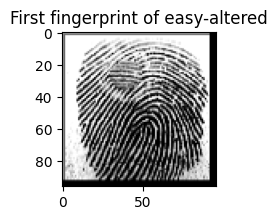

In [6]:
#printing the first fingerprint of easy altered folder
plt.figure(figsize=(2, 2))
plt.title("First fingerprint of easy-altered")
plt.imshow(X_easy[0], cmap='gray')

In [13]:
#separating image values for real data
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

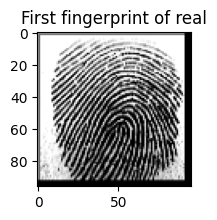

In [8]:
#printing the first real fingerprint
plt.figure(figsize=(2, 2))
plt.title("First fingerprint of real")
plt.imshow(X_test[0], cmap='gray')

In [9]:
#printing the shapes of the two models plus their training, validation and test data
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", X_easy.shape, y_SubjectID_easy.shape)
print("SubjectID_Train:      ", X_SubjectID_train_easy.shape, y_SubjectID_train_easy.shape)
print("SubjectID_Validation: ", X_SubjectID_val_easy.shape, y_SubjectID_val_easy.shape)
print("SubjectID_Test:       ", X_test.shape, y_SubjectID_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", X_easy.shape, y_fingerNum_easy.shape)
print("fingerNum_Train:      ", X_fingerNum_train_easy.shape, y_fingerNum_train_easy.shape)
print("fingerNum_Validation: ", X_fingerNum_val_easy.shape, y_fingerNum_val_easy.shape)
print("fingerNum_Test:       ", X_test.shape, y_fingerNum_test.shape)

#del Altered_data, Real_data, y_SubjectID_Altered # Free some memory againa  

Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (17931, 96, 96, 1) (17931, 600)
SubjectID_Train:       (14344, 96, 96, 1) (14344, 600)
SubjectID_Validation:  (3587, 96, 96, 1) (3587, 600)
SubjectID_Test:        (6000, 96, 96, 1) (6000, 600)
----------------------------------------------------
full fingerNum data:   (17931, 96, 96, 1) (17931, 10)
fingerNum_Train:       (14344, 96, 96, 1) (14344, 10)
fingerNum_Validation:  (3587, 96, 96, 1) (3587, 10)
fingerNum_Test:        (6000, 96, 96, 1) (6000, 10)


# Creating the two models

In [8]:
#creating two models including techniques like L2 regularization, batch normalization and dropout to prevent overfitting
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 92, 92, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 42, 42, 64)        256       
 chNormalization)                                                
                                                     

# Fitting subject ID model

In [10]:
#fitting the first model for subject ID 
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 15
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train_easy, y_SubjectID_train_easy,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val_easy, y_SubjectID_val_easy),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/15
225/225 [==============================] - 557s 2s/step - loss: 6.5653 - accuracy: 0.0020 - val_loss: 8.6854 - val_accuracy: 8.3635e-04 - lr: 1.0000e-04
Epoch 2/15
225/225 [==============================] - 409s 2s/step - loss: 6.3972 - accuracy: 0.0073 - val_loss: 7.7881 - val_accuracy: 0.0011 - lr: 1.0000e-04
Epoch 3/15
225/225 [==============================] - 420s 2s/step - loss: 6.1390 - accuracy: 0.0188 - val_loss: 6.1149 - val_accuracy: 0.0237 - lr: 1.0000e-04
Epoch 4/15
225/225 [==============================] - 406s 2s/step - loss: 5.6721 - accuracy: 0.0458 - val_loss: 5.5913 - val_accuracy: 0.0722 - lr: 1.0000e-04
Epoch 5/15
225/225 [==============================] - 406s 2s/step - loss: 4.9647 - accuracy: 0.1179 - val_loss: 4.8513 - val_accuracy: 0.1832 - lr: 1.0000e-04
Epoch 6/15
225/225 [==============================] - 365s 2s/step - loss: 4.0218 - accuracy: 0.2368 - val_loss: 3.9279 - val_accuracy: 0.3518 - lr: 1.0000e-04
Epoch 7/15
225/225 [================

113/113 [==============================] - 27s 173ms/step


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2140\1651992595.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


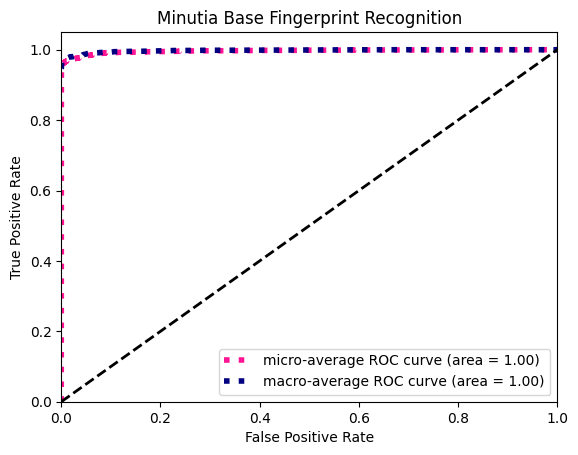

In [11]:
# ROC, AUC curves to show performance of the model
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


y_score = model[0].predict(X_SubjectID_val_easy)
y_test = y_SubjectID_val_easy
n_classes = y_test.shape[1]
# y_SubjectID_val

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Minutia Base Fingerprint Recognition')
plt.legend(loc="lower right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9867584332311123

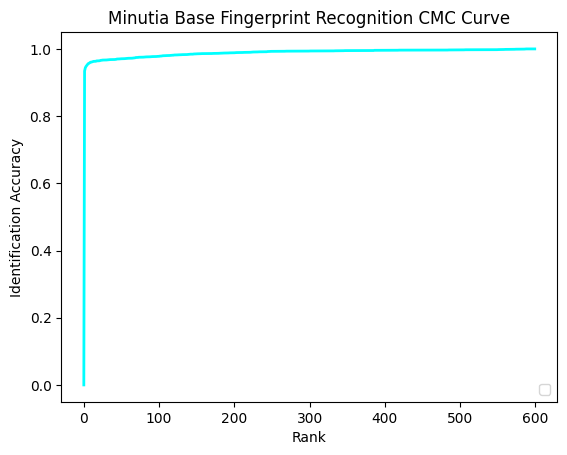

In [14]:
#CMC curve to analyse model performance
# Acc
(np.argmax(y_score, axis=1) == np.argmax(y_test, axis=1)).sum()/y_score.shape[0]

# CMC
rank = np.argsort(y_score,axis=1)[:,::-1]
label = np.argmax(y_test, axis=1)

cmc_curve = np.zeros(n_classes)
for k in range(n_classes):
    for i in range(len(label)): 
        if label[i] in rank[i,:k]:
            cmc_curve[k] += 1
    cmc_curve[k] /= len(label)


plt.plot(np.array(range(600)), cmc_curve, color='aqua', lw=lw,
          label='')
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('Minutia Base Fingerprint Recognition CMC Curve')
plt.legend(loc="lower right")
plt.legend(loc="lower right")

auc(np.array(range(600))/600, cmc_curve)

# Fitting finger name model

In [12]:
# Then reload fingerNum dataset before model fitting
#X_fingerNum_train_easy, X_fingerNum_val_easy, y_fingerNum_train_easy, y_fingerNum_val_easy = train_test_split(
    #X_easy, y_fingerNum_easy, test_size=0.2, random_state=2)

#del X_Altered, y_fingerNum_Altered

#fitting the second model for fingername
history[1] = model[1].fit(X_fingerNum_train_easy, y_fingerNum_train_easy,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val_easy, y_fingerNum_val_easy),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/15
225/225 [==============================] - 399s 2s/step - loss: 2.0565 - accuracy: 0.3425 - val_loss: 5.2944 - val_accuracy: 0.1525 - lr: 1.0000e-04
Epoch 2/15
225/225 [==============================] - 332s 1s/step - loss: 1.5186 - accuracy: 0.5029 - val_loss: 2.5168 - val_accuracy: 0.3315 - lr: 1.0000e-04
Epoch 3/15
225/225 [==============================] - 330s 1s/step - loss: 1.2731 - accuracy: 0.5907 - val_loss: 1.1596 - val_accuracy: 0.6342 - lr: 1.0000e-04
Epoch 4/15
225/225 [==============================] - 330s 1s/step - loss: 1.0632 - accuracy: 0.6652 - val_loss: 0.9577 - val_accuracy: 0.7089 - lr: 1.0000e-04
Epoch 5/15
225/225 [==============================] - 330s 1s/step - loss: 0.8842 - accuracy: 0.7276 - val_loss: 0.8571 - val_accuracy: 0.7536 - lr: 1.0000e-04
Epoch 6/15
225/225 [==============================] - 326s 1s/step - loss: 0.7278 - accuracy: 0.7881 - val_loss: 0.6974 - val_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 7/15
225/225 [====================

In [20]:
#tensorboard for hyperparameter tunning
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Launch TensorBoard
# Supervising the SubjectID model
%tensorboard --logdir './log_dir/SubjectID_log'
# or, supervising the fingerNum model
# %tensorboard --logdir './log_dir/fingerNum_log'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 15124.

# Model evaluation

Id recognition accuracy:  98.61666560173035 %
Finger recognition accuracy:  99.46666955947876 %


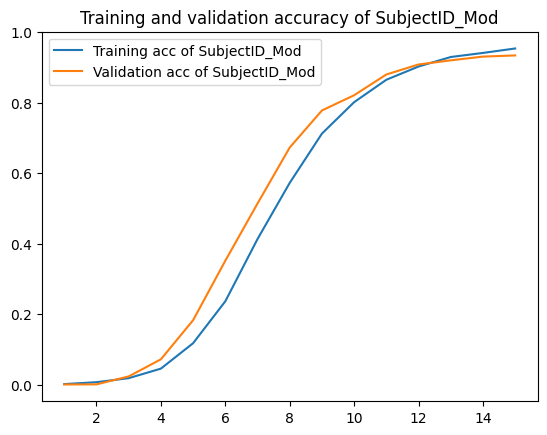

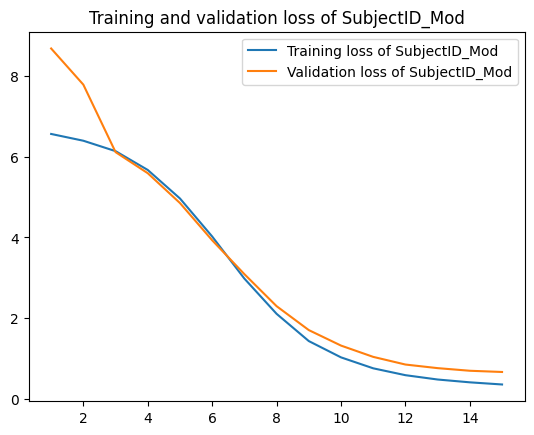

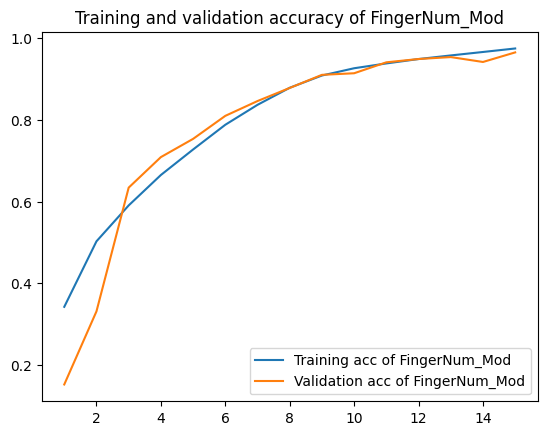

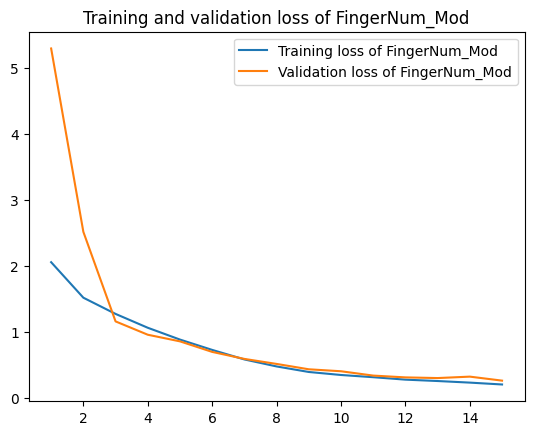

In [13]:
#plotting training and validation accuracy and loss for both models
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name
[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")


188/188 [==============================] - 47s 248ms/step
Evaluation Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       1.00      0.99      0.99       600
           2       0.99      1.00      1.00       600
           3       1.00      0.99      1.00       600
           4       1.00      1.00      1.00       600
           5       0.99      0.99      0.99       600
           6       0.99      0.99      0.99       600
           7       0.99      1.00      1.00       600
           8       1.00      0.99      1.00       600
           9       1.00      1.00      1.00       600

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



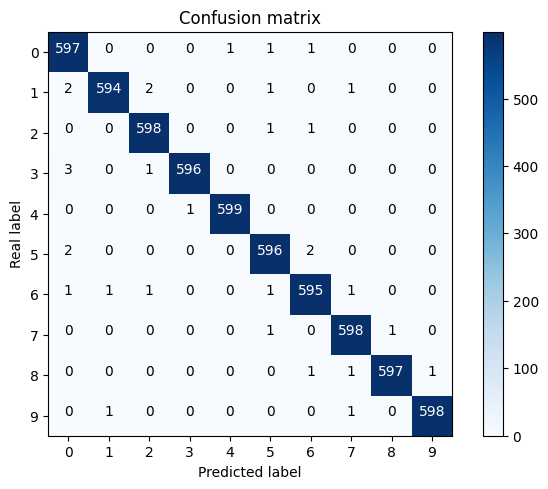

In [18]:
#Confusion matrix and classification report for evaluation of the fingername model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred_easy = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred_easy, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 
#Generate the evaluation report
report = classification_report(y_fingerNum_real, y_fingerNum_pred_classes)
print("Evaluation Report:")
print(report)




188/188 [==============================] - 50s 264ms/step
Infomation confirm! Fingerprint matches: person Id 598 right middle


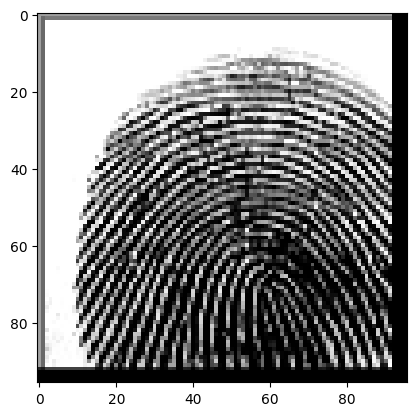

In [20]:
#function to show fingername
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred_easy = model[0].predict(X_test)
Id_pred_easy = np.argmax(y_SubjectID_pred_easy[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred_easy = np.argmax(y_fingerNum_pred_easy[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred_easy==Id_real and fingerNum_pred_easy==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred_easy, show_fingername(fingerNum_pred_easy))
else:
    print("Oops! Prediction is wrong!")

# Using Medium-Altered Fingerprints

In [5]:
#Separating image values and labels of medium altered images
X_medium, y_SubjectID_medium, y_fingerNum_medium = [], [], []

for SubjectID, fingerNum, feature in Medium_data:
    X_medium.append(feature)
    y_SubjectID_medium.append(SubjectID)
    y_fingerNum_medium.append(fingerNum)

X_medium = np.array(X_medium).reshape(-1, img_size, img_size, 1)
X_medium = X_medium / 255.0 # Normalize to [0, 1]
y_SubjectID_medium = to_categorical(y_SubjectID_medium, num_classes=600) # 600 persons in total
y_fingerNum_medium = to_categorical(y_fingerNum_medium, num_classes=10) # 10 fingers per person



In [6]:
#splitting data into training and validation for the two models
X_SubjectID_train_medium, X_SubjectID_val_medium, y_SubjectID_train_medium, y_SubjectID_val_medium = train_test_split(
    X_medium, y_SubjectID_medium, test_size=0.1, random_state=2)
X_fingerNum_train_medium, X_fingerNum_val_medium, y_fingerNum_train_medium, y_fingerNum_val_medium = train_test_split(
    X_medium, y_fingerNum_medium, test_size=0.1, random_state=2)


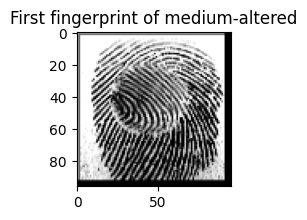

In [21]:
#printing the first fingerprint of medium altered folder
plt.figure(figsize=(2, 2))
plt.title("First fingerprint of medium-altered")
plt.imshow(X_medium[0], cmap='gray')

In [9]:
#fitting the first model for subject ID 
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 15
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_SubjectID_train_medium, y_SubjectID_train_medium,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val_medium, y_SubjectID_val_medium),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/15
240/240 [==============================] - 524s 2s/step - loss: 6.5786 - accuracy: 0.0020 - val_loss: 7.9673 - val_accuracy: 0.0029 - lr: 1.0000e-04
Epoch 2/15
240/240 [==============================] - 408s 2s/step - loss: 6.4803 - accuracy: 0.0046 - val_loss: 6.8541 - val_accuracy: 0.0018 - lr: 1.0000e-04
Epoch 3/15
240/240 [==============================] - 393s 2s/step - loss: 6.3167 - accuracy: 0.0102 - val_loss: 6.2356 - val_accuracy: 0.0070 - lr: 1.0000e-04
Epoch 4/15
240/240 [==============================] - 393s 2s/step - loss: 6.0596 - accuracy: 0.0193 - val_loss: 5.9680 - val_accuracy: 0.0252 - lr: 1.0000e-04
Epoch 5/15
240/240 [==============================] - 409s 2s/step - loss: 5.6753 - accuracy: 0.0434 - val_loss: 5.6427 - val_accuracy: 0.0516 - lr: 1.0000e-04
Epoch 6/15
240/240 [==============================] - 358s 1s/step - loss: 5.1202 - accuracy: 0.0899 - val_loss: 5.1418 - val_accuracy: 0.1131 - lr: 1.0000e-04
Epoch 7/15
240/240 [====================

107/107 [==============================] - 21s 171ms/step


C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8700\1641828844.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


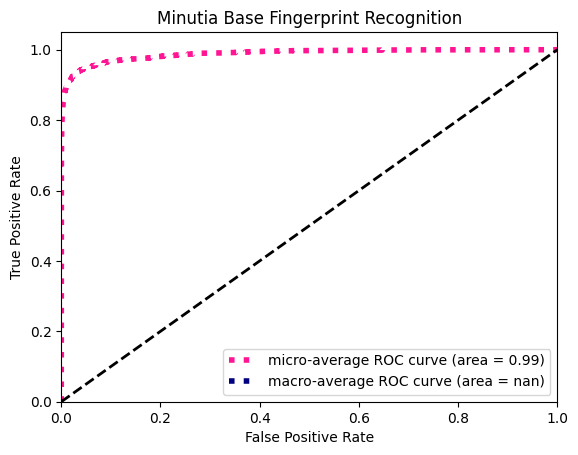

In [9]:
# ROC, AUC curves to show performance of the model
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


y_score = model[0].predict(X_SubjectID_val_medium)
y_test = y_SubjectID_val_medium
n_classes = y_test.shape[1]
# y_SubjectID_val

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Minutia Base Fingerprint Recognition')
plt.legend(loc="lower right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9789938488576451

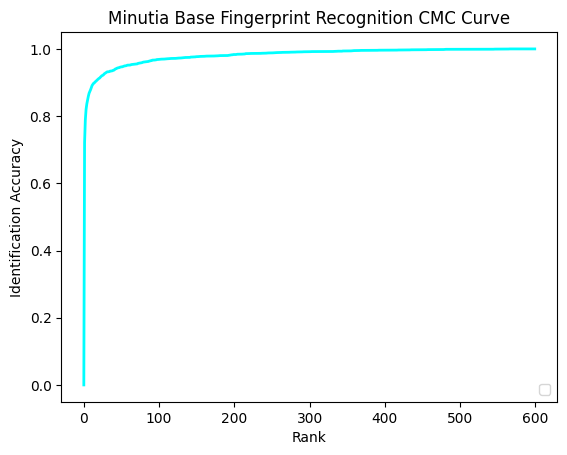

In [10]:
#CMC curve to analyse model performance
# Acc
(np.argmax(y_score, axis=1) == np.argmax(y_test, axis=1)).sum()/y_score.shape[0]

# CMC
rank = np.argsort(y_score,axis=1)[:,::-1]
label = np.argmax(y_test, axis=1)

cmc_curve = np.zeros(n_classes)
for k in range(n_classes):
    for i in range(len(label)): 
        if label[i] in rank[i,:k]:
            cmc_curve[k] += 1
    cmc_curve[k] /= len(label)


plt.plot(np.array(range(600)), cmc_curve, color='aqua', lw=lw,
          label='')
plt.xlabel('Rank')
plt.ylabel('Identification Accuracy')
plt.title('Minutia Base Fingerprint Recognition CMC Curve')
plt.legend(loc="lower right")
plt.legend(loc="lower right")

auc(np.array(range(600))/600, cmc_curve)

In [10]:
#fitting the second model for fingername
history[1] = model[1].fit(X_fingerNum_train_medium, y_fingerNum_train_medium,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val_medium, y_fingerNum_val_medium),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/15
240/240 [==============================] - 452s 2s/step - loss: 2.0408 - accuracy: 0.3492 - val_loss: 5.4287 - val_accuracy: 0.0978 - lr: 1.0000e-04
Epoch 2/15
240/240 [==============================] - 423s 2s/step - loss: 1.5432 - accuracy: 0.4953 - val_loss: 1.9319 - val_accuracy: 0.4183 - lr: 1.0000e-04
Epoch 3/15
240/240 [==============================] - 406s 2s/step - loss: 1.3313 - accuracy: 0.5706 - val_loss: 1.2990 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 4/15
240/240 [==============================] - 464s 2s/step - loss: 1.1483 - accuracy: 0.6360 - val_loss: 1.1193 - val_accuracy: 0.6339 - lr: 1.0000e-04
Epoch 5/15
240/240 [==============================] - 378s 2s/step - loss: 1.0005 - accuracy: 0.6829 - val_loss: 1.0105 - val_accuracy: 0.6807 - lr: 1.0000e-04
Epoch 6/15
240/240 [==============================] - 418s 2s/step - loss: 0.8506 - accuracy: 0.7366 - val_loss: 0.9434 - val_accuracy: 0.7036 - lr: 1.0000e-04
Epoch 7/15
240/240 [====================

Id recognition accuracy:  96.96666598320007 %
Finger recognition accuracy:  97.50000238418579 %


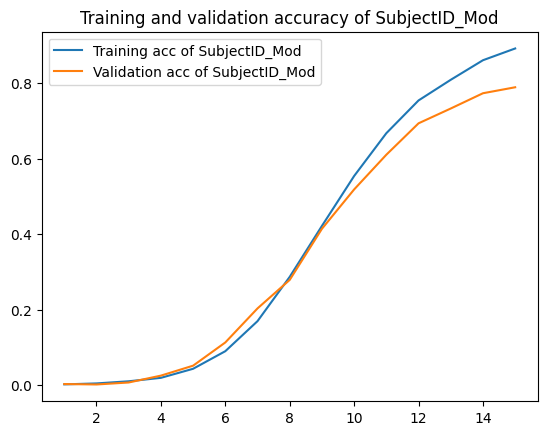

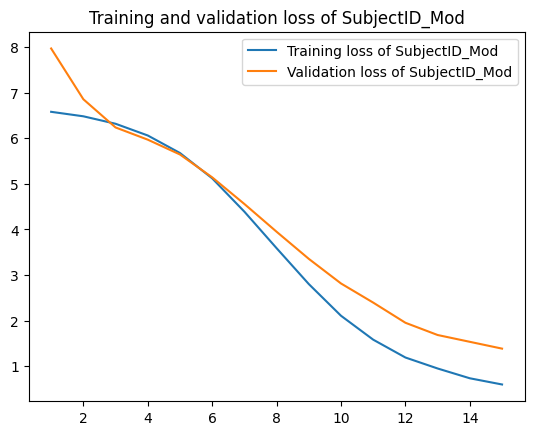

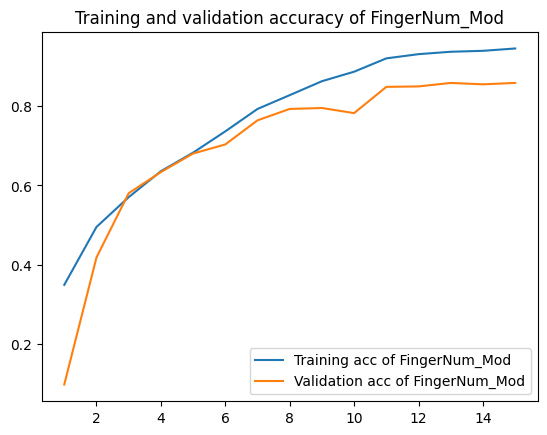

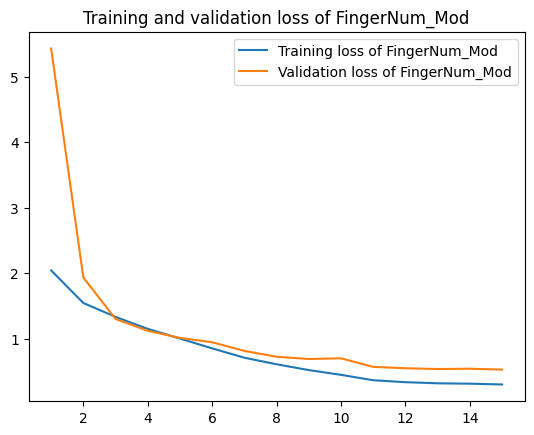

In [14]:
#plotting training and validation accuracy and loss for both models
%matplotlib inline
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name
[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")


188/188 [==============================] - 53s 259ms/step
Evaluation Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       600
           1       0.92      0.92      0.92       600
           2       0.94      0.95      0.95       600
           3       0.94      0.94      0.94       600
           4       0.99      0.98      0.98       600
           5       0.95      0.94      0.94       600
           6       0.94      0.94      0.94       600
           7       0.96      0.94      0.95       600
           8       0.97      0.97      0.97       600
           9       0.99      1.00      0.99       600

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



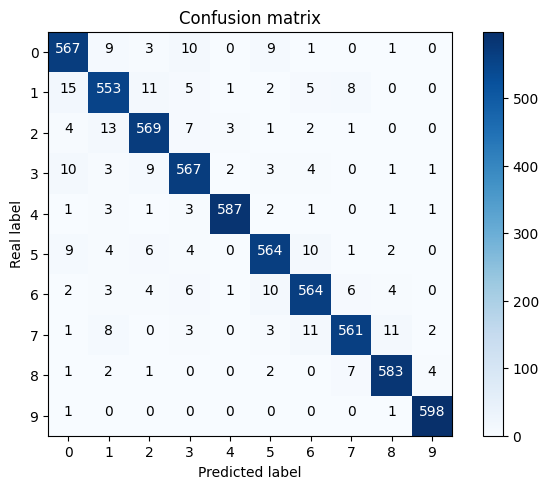

In [15]:
#Confusion matrix and classification report for evaluation of the fingername model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred_medium = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred_medium, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 
#Generate the evaluation report
report = classification_report(y_fingerNum_real, y_fingerNum_pred_classes)
print("Evaluation Report:")
print(report)




188/188 [==============================] - 39s 177ms/step
Infomation confirm! Fingerprint matches: person Id 23 left little


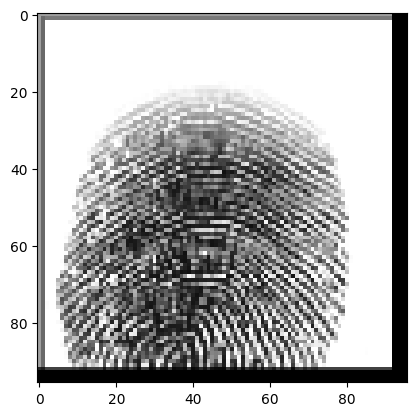

In [18]:
#function to show fingername
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred_medium = model[0].predict(X_test)
Id_pred_medium = np.argmax(y_SubjectID_pred_medium[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred_medium = np.argmax(y_fingerNum_pred_medium[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred_medium==Id_real and fingerNum_pred_medium==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred_medium, show_fingername(fingerNum_pred_medium))
else:
    print("Oops! Prediction is wrong!")